In [10]:
#!/usr/bin/python3

# Анализ отсчетов о небесных Объектах

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pycountry
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from yandex_translate import YandexTranslate
from yandex_translate import YandexTranslateException

YANDEX_API_KEY = 'trnsl.1.1.20180114T103300Z.b0bbc6e678d32652.103a2256f272e0d5b22abf173ef9707a59bde6c4'
PLOT_LABEL_FONT_SIZE = 14 

# Генерация цветовой схемы
# Возвращает список цветов
def getColors(n):
    COLORS = []
    cm = plt.cm.get_cmap('hsv', n)
    for i in np.arange(n):
        COLORS.append(cm(i))
    return COLORS

# Установка размера 2D графика
def set_plot_size(w,h,figure=plt):
    fig_size = plt.rcParams['figure.figsize']
    fig_size[0] = 12
    fig_size[1] = 4.5
    figure.rcParams['figure.figsize'] = fig_size

set_plot_size(12, 4.5)

# Перевести строку с англиского на русский язык
# string - строка, которую нужно перевести
# translator_class - объект в котором реализован переводчик, если равен None, то строка не переводится
# Возвращает переведенную на русский язык строку
def translate(string, translator_class=None):
    if translator_class == None: 
        return string
    t = translator_class.translate(string, 'en-ru')
    return t['text'][0]

# Отсортировать словарь в убывающем порядке по значениям и разбить его на два списка - ключи, значения
# Возвращает кортеж {список ключей, список значений}
def dict_sort(my_dict):
    keys = []
    values = []
    my_dict = sorted(my_dict.items(), key=lambda x:x[1], reverse=True)
    for k, v in my_dict:
        keys.append(k)
        values.append(v)
    return (keys,values)

# Инициализация объекта переводчика
# Если YANDEX_API_KEY неправильный или не задан, то объект инициализируется None, и перевод строк будет игнорироваться
try:
    translate_obj = YandexTranslate(YANDEX_API_KEY)
except YandexTranslateException:
    translate_obj = None 

# Чтение CSV файла
df = pd.read_csv('./scrubbed.csv', escapechar='`', low_memory=False)

# В некоторых полях таблицы есть поля со значением None
# Некоторые алгоритмы анализа могут работать некорректно с этим значением
# Мы произведем замену None на значение 'unknown' в полях таблицы
# Эта процедура называется инпутацией
df = df.replace({'shape':None}, 'unknown')

# Поменяем коды стран на названия на русском языке
country_label_count = pd.value_counts(df['country'].values, sort=True)
for label in list(country_label_count.keys()):
    c = pycountry.countries.get(alpha_2=str(label).upper())
    t = translate(c.name, translate_obj)
    df = df.replace({'country':str(label)}, t)

shapes_label_count = pd.value_counts(df['shape'].values, sort=True)

# Переведем все названия НЛО на русский язык
for label in list(shapes_label_count.keys()):
    t = translate(str(label), translate_obj)
    df = df.replace({'shape':str(label)}, t)

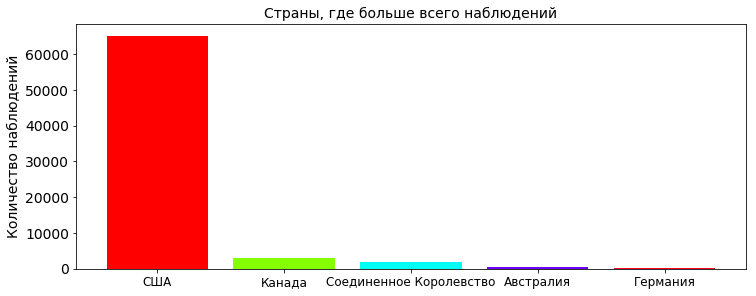

In [11]:
country_count = pd.value_counts(df['country'].values, sort=True)
country_count_keys, country_count_values = dict_sort(dict(country_count))    
TOP_COUNTRY = len(country_count_keys)
plt.title('Страны, где больше всего наблюдений', fontsize=PLOT_LABEL_FONT_SIZE)
plt.bar(np.arange(TOP_COUNTRY), country_count_values, color=getColors(TOP_COUNTRY))
plt.xticks(np.arange(TOP_COUNTRY), country_count_keys, rotation=0, fontsize=12)
plt.yticks(fontsize=PLOT_LABEL_FONT_SIZE) 
plt.ylabel('Количество наблюдений', fontsize=PLOT_LABEL_FONT_SIZE)
plt.show()

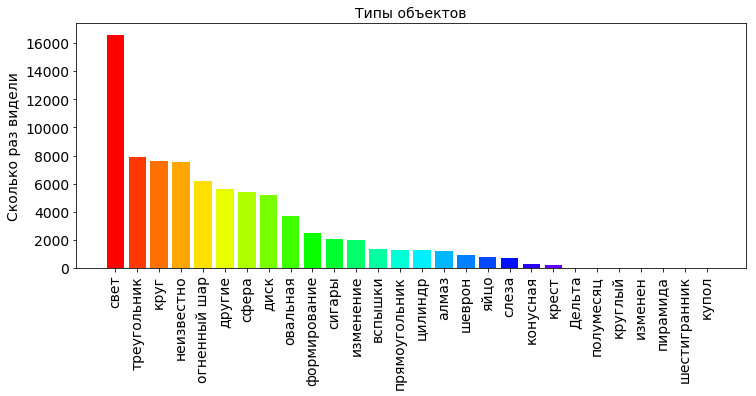

In [12]:
# Больше всего случев естественно в США
# Построим гистограмму показывающую частоту с которой встречаются разные виды НЛО

shapes_type_count = pd.value_counts(df['shape'].values, sort=True)
shapes_type_count_keys, shapes_type_count_values = dict_sort(dict(shapes_type_count))   
OBJECT_COUNT = len(shapes_type_count_keys)
plt.title('Типы объектов', fontsize=PLOT_LABEL_FONT_SIZE)
bar = plt.bar(np.arange(OBJECT_COUNT), shapes_type_count_values, color=getColors(OBJECT_COUNT))
plt.xticks(np.arange(OBJECT_COUNT), shapes_type_count_keys, rotation=90, fontsize=PLOT_LABEL_FONT_SIZE)
plt.yticks(fontsize=PLOT_LABEL_FONT_SIZE)
plt.ylabel('Сколько раз видели', fontsize=PLOT_LABEL_FONT_SIZE)
plt.show()

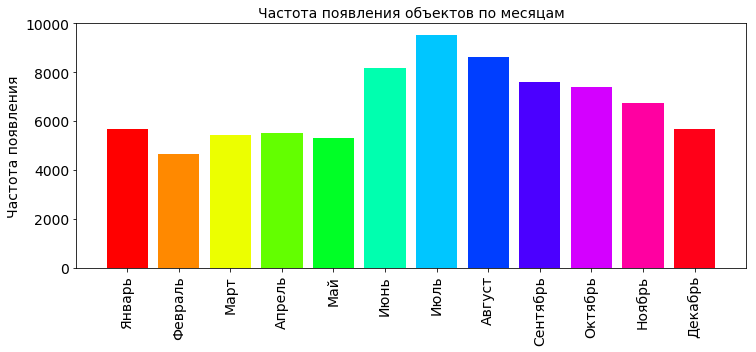

In [13]:
# Из графика мы видим что больше всего на небе видели просто свечение
# Всяких кругов и треугольников значительно меньше
# Посмотрим в какие месяцы больше всего туристов

MONTH_COUNT = [0,0,0,0,0,0,0,0,0,0,0,0]
MONTH_LABEL = ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь',
    'Июль', 'Август', 'Сентябрь' ,'Октябрь' ,'Ноябрь' ,'Декабрь']

for i in df['datetime']:
    m,d,y_t =  i.split('/')
    MONTH_COUNT[int(m)-1] = MONTH_COUNT[int(m)-1] + 1

plt.bar(np.arange(12), MONTH_COUNT, color=getColors(12))
plt.xticks(np.arange(12), MONTH_LABEL, rotation=90, fontsize=PLOT_LABEL_FONT_SIZE)
plt.ylabel('Частота появления', fontsize=PLOT_LABEL_FONT_SIZE)
plt.yticks(fontsize=PLOT_LABEL_FONT_SIZE)
plt.title('Частота появления объектов по месяцам', fontsize=PLOT_LABEL_FONT_SIZE)
plt.show()

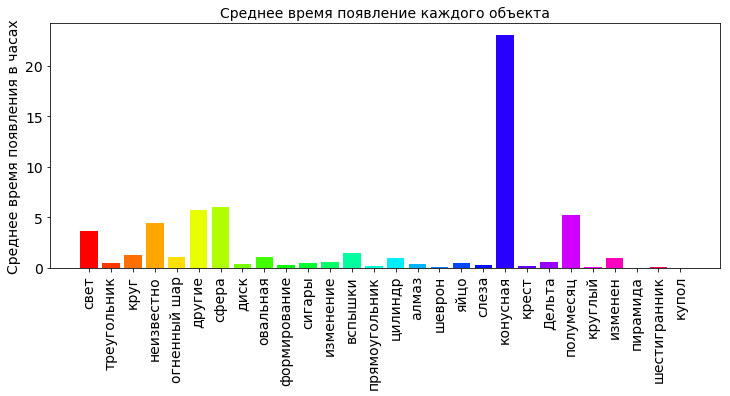

In [14]:
# Для интереса посмотрим время на которое появлялись разные объекты на небе

shapes_durations_dict = {}
for i in shapes_type_count_keys:
     dfs = df[['duration (seconds)', 'shape']].loc[df['shape'] == i]   
     shapes_durations_dict[i] = dfs['duration (seconds)'].mean(axis=0)/60.0/60.0
    
#shapes_durations_dict_keys, shapes_durations_dict_values = dict_sort(shapes_durations_dict)
shapes_durations_dict_keys = []
shapes_durations_dict_values = []
for k in shapes_type_count_keys:
    shapes_durations_dict_keys.append(k)
    shapes_durations_dict_values.append(shapes_durations_dict[k])
    
plt.title('Среднее время появление каждого объекта', fontsize=PLOT_LABEL_FONT_SIZE)
plt.bar(np.arange(OBJECT_COUNT), shapes_durations_dict_values, color=getColors(OBJECT_COUNT))
plt.xticks(np.arange(OBJECT_COUNT), shapes_durations_dict_keys, rotation=90, fontsize=PLOT_LABEL_FONT_SIZE)
plt.yticks(fontsize=PLOT_LABEL_FONT_SIZE)
plt.ylabel('Среднее время появления в часах', fontsize=PLOT_LABEL_FONT_SIZE)
plt.show()


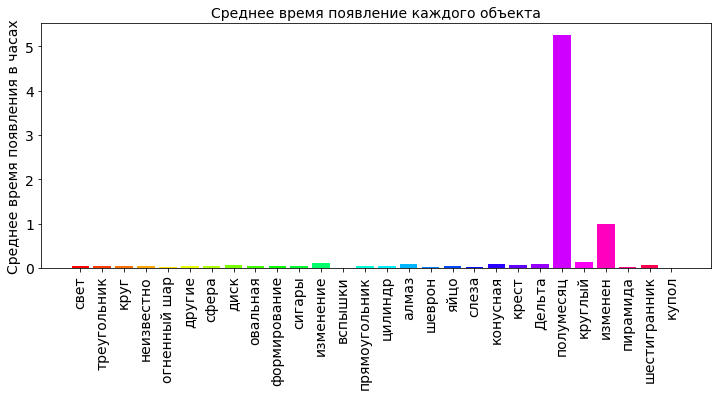

In [15]:
shapes_durations_dict = {}
for i in shapes_type_count_keys:
     dfs = df[['duration (seconds)', 'shape']].loc[df['shape'] == i]   
     shapes_durations_dict[i] = dfs['duration (seconds)'].median(axis=0)/60.0/60.0
    
shapes_durations_dict_keys = []
shapes_durations_dict_values = []
for k in shapes_type_count_keys:
    shapes_durations_dict_keys.append(k)
    shapes_durations_dict_values.append(shapes_durations_dict[k])

plt.title('Среднее время появление каждого объекта', fontsize=PLOT_LABEL_FONT_SIZE)
plt.bar(np.arange(OBJECT_COUNT), shapes_durations_dict_values, color=getColors(OBJECT_COUNT))
plt.xticks(np.arange(OBJECT_COUNT), shapes_durations_dict_keys, rotation=90, fontsize=PLOT_LABEL_FONT_SIZE)
plt.yticks(fontsize=PLOT_LABEL_FONT_SIZE)
plt.ylabel('Среднее время появления в часах', fontsize=PLOT_LABEL_FONT_SIZE)
plt.show()